# Segment Outline PNGs with Contour Masks and SAM2

In [1]:
%reload_ext autoreload
%autoreload 2

import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import random
import pandas as pd
from PIL import Image, ImageEnhance
from tqdm import tqdm
from collections import Counter

# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

# Set seed for other libraries if necessary
np.random.seed(SEED)
random.seed(SEED)

fontsize=14

In [2]:
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.float16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
WORK = Path(os.environ.get("WORK", Path.cwd()))
print("WORK:", WORK)

WORK: /mnt/lustre/work/eickhoff/esx061


In [123]:
#%git clone https://github.com/facebookresearch/sam2.git

In [4]:
sam_dir = WORK / "color-concept-entanglement" / "segment-anything-2"
os.chdir(sam_dir)
%pip install -e .

Obtaining file:///mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp311-cp311-linux_x86_64.whl size=13903 sha256=be52576633ee954f3da025bec5c1c6f0697b381754cbf208295d0eb6858a417d
  Stored in directory: /tmp/pip-ephem-wheel-cache-vxfvs9a2/wheels/a4/f1/43/0f0846a883930be4032817d76dba580924698cf6ff9d2dcc7a
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
Note: you may need to restart the kernel to use updated packages.


In [125]:
# @title
# !mkdir -p {WORK}/color-concept-entanglement/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {WORK}/color-concept-entanglement/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {WORK}/color-concept-entanglement/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/segment-anything-2/checkpoints

In [5]:
# Base data folder
data_folder = WORK / "color-concept-entanglement" / "data"

# Paths
IN_DIR   = data_folder / "outline_images"
OUT_DIR  = data_folder / "color_images"
CV_MASKS = data_folder / "cv_masks"
SAM_MASKS= data_folder / "sam_masks"

out_path = data_folder / "segmented_images.csv"

# Create needed directories
OUT_DIR.mkdir(parents=True, exist_ok=True)
CV_MASKS.mkdir(parents=True, exist_ok=True)
SAM_MASKS.mkdir(parents=True, exist_ok=True)

# Load CSV
df = pd.read_csv(data_folder / "final_images.csv")

# CV2 mask quality thresholds
MIN_FG = 0.055   # min acceptable foreground ratio (avoid empty masks)
MAX_FG = 0.98   # max acceptable foreground ratio (avoid filled squares)

# SAM2 model setup (edit if you have SAM2 locally)
# - model_cfg is one of the YAMLs in the SAM2 repo (e.g., sam2_hiera_s.yaml)
# - ckpt points to the checkpoint file you downloaded
SAM2_ENABLED = True   # set False to skip SAM2 even if available
model_cfg = "configs/sam2/sam2_hiera_l.yaml"   # e.g., "/path/to/sam2/configs/sam2_hiera_s.yaml"
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"        # e.g., "/path/to/ckpts/sam2_hiera_s.pth"
DEVICE = "cuda"       # "cuda" or "cpu" (cuda recommended for speed)


In [6]:
df

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0
...,...,...,...,...,...,...,...,...,...
221,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0
222,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0
223,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0
224,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0


## SAM 2

In [7]:
# Try importing SAM2 if installed
SAM2_AVAILABLE = False
if SAM2_ENABLED:
    try:
        from sam2.build_sam import build_sam2
        from sam2.sam2_image_predictor import SAM2ImagePredictor
        SAM2_AVAILABLE = True
        sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
        predictor = SAM2ImagePredictor(sam2_model)
        print("SAM2 is available.")
    except Exception as e:
        print("SAM2 not available or failed to import:", e)
        SAM2_AVAILABLE = False

print("OpenCV version:", cv2.__version__)

SAM2 is available.
OpenCV version: 4.12.0


In [8]:
def show_points(coords, labels, ax, marker_size=375):
    """Sam2 function to show points."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """Sam2 function to show the box over the image."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_mask(mask, ax, random_color=False, borders = True):
    """Visualize mask in the image"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    """Plot ALL images masks in a set"""
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [9]:
def fix_inverse_mask(mask, edge_threshold=0.05, center_fraction=0.5):
    """
    Detects if a SAM-generated mask is inverted and corrects it if necessary.

    Args:
        mask (np.array): A 256x256 binary mask.
        edge_threshold (float): The fraction of the image width/height to consider as an edge.
        center_fraction (float): The fraction of the image width/height to consider as the central region.

    Returns:
        np.array: The corrected mask.
    """
    mask = mask[0]
    height, width = mask.shape

    # Define center region
    center_x_min = int((1 - center_fraction) / 2 * width)
    center_x_max = int((1 + center_fraction) / 2 * width)
    center_y_min = int((1 - center_fraction) / 2 * height)
    center_y_max = int((1 + center_fraction) / 2 * height)

    center_region = mask[center_y_min:center_y_max, center_x_min:center_x_max]

    # Count object and background pixels in the center
    object_count = np.sum(center_region == 1)
    background_count = np.sum(center_region == 0)

    # Define edge regions
    edge_size = int(edge_threshold * width)

    top_edge = mask[:edge_size, :]
    bottom_edge = mask[-edge_size:, :]
    left_edge = mask[:, :edge_size]
    right_edge = mask[:, -edge_size:]

    edges = np.concatenate([top_edge.flatten(), bottom_edge.flatten(), left_edge.flatten(), right_edge.flatten()])

    # Count object and background pixels in the edges
    edge_object_count = np.sum(edges == 1)
    edge_background_count = np.sum(edges == 0)

    # If the center is mostly background (0) and edges are mostly object (1), it's likely inverted
    if background_count > object_count and edge_object_count > edge_background_count:
        return np.expand_dims(1-mask, axis=0)  # Invert the mask

    return np.expand_dims(mask, axis=0)  # Return as is if not inverted

In [10]:
def find_bounding_box_with_threshold(image, block_size=11, C=2):
    """
    Compute a bounding box for an image using adaptive thresholding.
    Assumes that the image is in grayscale mode (PIL 'L').
    """
    np_img = np.array(image)
    # Adaptive thresholding: invert so that white objects become dark and easier to find.
    thresh = cv2.adaptiveThreshold(
        np_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, block_size, C
    )

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return (0, 0, image.width - 1, image.height - 1)

    # Combine all contours to get a bounding rectangle that encompasses them
    all_contours = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_contours)
    return (x, y, x + w, y + h)

def pad_bbox(bbox, pad, img_width, img_height):
    """Expands the bounding box by a pad value while remaining within image boundaries."""
    x1, y1, x2, y2 = bbox
    x1 = max(x1 - pad, 0)
    y1 = max(y1 - pad, 0)
    x2 = min(x2 + pad, img_width - 1)
    y2 = min(y2 + pad, img_height - 1)
    return (x1, y1, x2, y2)

## Contour Maps with cv2

In [11]:
def get_cv_mask(
    gray_u8: np.ndarray,
    block_size: int = 15,  # odd
    C: int = 9,
    dilate_px: int = 1,
    close_px: int = 3,
    pad: int = 16,
    min_area_px: int = 0,
    keep_largest: bool = False,
    target_size: tuple | None = None,  # (H_img, W_img)
    smooth: bool = False,
) -> np.uint8:
    """
    Make a filled object mask where all corners are guaranteed background.
    Returns uint8 mask (0/255).
    If target_size is given and different from gray_u8.shape, the mask is resized to it.
    """
    h, w = gray_u8.shape[:2]
    bs = block_size if block_size % 2 else block_size + 1

    # Detect outline as walls
    walls = cv2.adaptiveThreshold(
        gray_u8, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
        bs, C
    )
    if dilate_px > 0:
        walls = cv2.dilate(
            walls,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_px, dilate_px)),
            1,
        )
    if close_px > 0:
        walls = cv2.morphologyEx(
            walls,
            cv2.MORPH_CLOSE,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_px, close_px)),
        )

    # Pad with free space
    P = int(max(1, pad))
    ph, pw = h + 2 * P, w + 2 * P
    walls_pad = np.zeros((ph, pw), np.uint8)
    walls_pad[P:P + h, P:P + w] = walls

    # Flood through free space from all four padded corners
    free = (walls_pad == 0).astype(np.uint8)
    flood = free.copy()
    ff_mask = np.zeros((ph + 2, pw + 2), np.uint8)

    seeds = [(0, 0), (0, pw - 1), (ph - 1, 0), (ph - 1, pw - 1)]
    for sx, sy in seeds:
        cv2.floodFill(flood, ff_mask, (sy, sx), 2)

    # Background = flood==2; Object = not background
    bg_pad = (flood == 2).astype(np.uint8)
    fg_pad = (bg_pad == 0).astype(np.uint8) * 255

    # Unpad back to original size
    fg = fg_pad[P:P + h, P:P + w]

    # Optional cleanup
    if keep_largest or (min_area_px and min_area_px > 0):
        n, lbl, stats, _ = cv2.connectedComponentsWithStats((fg > 0).astype(np.uint8), 8)
        if n > 1:
            if keep_largest:
                largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                fg = np.where(lbl == largest, 255, 0).astype(np.uint8)
            else:
                keep = np.zeros_like(fg)
                for i in range(1, n):
                    if stats[i, cv2.CC_STAT_AREA] >= int(min_area_px):
                        keep[lbl == i] = 255
                fg = keep

    # Optional resize
    if target_size is not None:
        H_img, W_img = target_size
        fg = cv2.resize(fg, (W_img, H_img), interpolation=cv2.INTER_LINEAR)
        fg = (fg > 127).astype(np.uint8) * 255

    if smooth:
        fg = cv2.GaussianBlur(fg, (3, 3), 0)
        fg = (fg > 127).astype(np.uint8) * 255

    return fg

## cv2 vs. SAM2

In [12]:
# Check image sizes 
sizes = []
for path in tqdm(df["image_path"], desc="Checking image sizes"):
    with Image.open(path) as im:
        sizes.append(im.size)  # (W, H)

counter = Counter(sizes)

print(f"Unique sizes: {len(counter)}")
for (w, h), count in counter.most_common():
    print(f"{w:4d} x {h:4d}  -> {count} images")


Checking image sizes: 100%|██████████| 226/226 [00:00<00:00, 716.45it/s]

Unique sizes: 120
 626 x  626  -> 42 images
 612 x  612  -> 15 images
 512 x  512  -> 11 images
 600 x  600  -> 10 images
1200 x 1200  -> 9 images
 360 x  360  -> 8 images
 800 x  800  -> 6 images
2500 x 2500  -> 4 images
 740 x  740  -> 3 images
 540 x  360  -> 3 images
 626 x  417  -> 2 images
 522 x  626  -> 2 images
1024 x 1024  -> 2 images
 613 x  860  -> 2 images
 470 x  626  -> 2 images
 800 x  821  -> 1 images
1024 x 1366  -> 1 images
 595 x  360  -> 1 images
 432 x  612  -> 1 images
 564 x  600  -> 1 images
 612 x  445  -> 1 images
1080 x 1080  -> 1 images
 608 x  626  -> 1 images
 512 x  626  -> 1 images
 300 x  300  -> 1 images
 314 x  360  -> 1 images
 735 x  460  -> 1 images
 599 x  600  -> 1 images
 589 x  600  -> 1 images
 514 x  360  -> 1 images
 587 x  612  -> 1 images
 530 x  600  -> 1 images
1664 x 1664  -> 1 images
 360 x  492  -> 1 images
4000 x 4000  -> 1 images
 600 x  599  -> 1 images
 735 x  568  -> 1 images
 636 x  900  -> 1 images
 736 x  573  -> 1 images
 60

In [13]:
# Compute cv2 and SAM2 masks for all images and store them
def create_masks(df, dilate_px: int = 1, close_px: int = 1):

    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing images"):
        orig_img = Image.open(row["image_path"]).convert("RGB")
        orig_w, orig_h = orig_img.size

        # Grayscale version at original resolution
        orig_gray = ImageEnhance.Contrast(orig_img).enhance(2.0).convert("L")
        orig_gray_u8 = np.array(orig_gray, dtype=np.uint8)

        # 256×256 version ONLY for detection + SAM
        DETECT_SIZE = 256
        img_small = orig_img.resize((DETECT_SIZE, DETECT_SIZE), Image.LANCZOS)
        enhanced_small_gray = ImageEnhance.Contrast(img_small).enhance(2.0).convert("L")

        # Compute bounding box over the edited image.
        bbox = find_bounding_box_with_threshold(enhanced_small_gray, block_size=11, C=2)
        bbox = pad_bbox(bbox, pad=8, img_width=img_small.width, img_height=img_small.height)

        # ---- CV MASK ----
        cv_mask = get_cv_mask(
            orig_gray_u8,
            block_size=15,
            pad=64,
            target_size=None,  
            smooth=True,
            close_px=close_px,
            dilate_px=dilate_px                  
        ).astype(np.uint8)

        cv_fg = (cv_mask > 0).mean()
        #print(f"CV fg ratio: {cv_fg:.3f}  bbox={bbox}")

        # ---- SAM ----
        # Set the original (non-contrast) image for the predictor
        predictor.set_image(img_small)

        # Run SAM predictor with bounding box
        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=np.array(bbox)[None, :],
            multimask_output=False,
        )

        # Sort by score
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        # Fix inverse if needed
        masks = fix_inverse_mask(masks)

        # Keep top SAM mask (H, W) as uint8 0/255 for display/ops
        sam_small_mask = (masks[0].astype(bool).astype(np.uint8)) * 255

        # upscale SAM mask to original resolution
        sam_mask = cv2.resize(
            sam_small_mask,
            (orig_w, orig_h),
            interpolation=cv2.INTER_LINEAR
        )

        # ---- Save masks to disk ----
        stem = Path(row["image_path"]).stem
        cv_path  = CV_MASKS / f"{stem}_cv_mask.png"
        sam_path = SAM_MASKS / f"{stem}_sam_mask.png"

        cv2.imwrite(str(cv_path),  cv_mask)
        cv2.imwrite(str(sam_path), sam_mask)

        # (Optional) also save .npy for exact downstream use
        # np.save(CV_DIR / f"{stem}_cv_mask.npy",  (cv_mask > 0).astype(np.uint8))
        # np.save(SAM_DIR / f"{stem}_sam_mask.npy", (sam_mask > 0).astype(np.uint8))

        df.at[idx, "cv_mask_path"]  = str(cv_path)
        df.at[idx, "sam_mask_path"] = str(sam_path)

In [14]:
# Display helpers
def checkerboard_pil(size, cell=16):
    w, h = size
    yy, xx = np.ogrid[:h, :w]
    cb = (((xx//cell) + (yy//cell)) % 2) * 255
    return Image.fromarray(np.stack([cb, cb, cb], axis=-1).astype(np.uint8))

def composite_on_checker(img_rgb_pil, mask_u8):
    """Return an RGB preview composited over a checkerboard using mask as alpha."""
    rgba = img_rgb_pil.convert("RGBA")
    alpha = Image.fromarray(mask_u8).convert("L")
    rgba.putalpha(alpha)
    bg = checkerboard_pil(rgba.size, cell=16).convert("RGBA")
    return Image.alpha_composite(bg, rgba).convert("RGB")

def load_mask(mask_path: str, size=None) -> np.ndarray:
    """Load single-channel mask PNG -> uint8 0/255. Optionally resize to size=(W,H)."""
    m = Image.open(mask_path).convert("L")
    if size is not None and m.size != size:
        m = m.resize(size, Image.NEAREST)
    arr = np.array(m, dtype=np.uint8)
    # normalize to 0/255 if it’s 0/1
    if arr.max() == 1:
        arr = arr * 255
    return arr

def show_gallery(df: pd.DataFrame, k: int = 10):
    required = {"image_path", "cv_mask_path", "sam_mask_path"}
    missing_cols = required - set(df.columns)
    if missing_cols:
        raise ValueError(f"df is missing columns: {sorted(missing_cols)}")

    if len(df) == 0:
        print("DataFrame is empty.")
        return

    df_sample = df.sample(min(k, len(df)))

    tiles = []
    for _, row in df_sample.iterrows():
        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except Exception as e:
            print(f"Skip (image load failed): {row.get('image_path')} -> {e}")
            continue

        cv_mask_path  = row.get("cv_mask_path")
        sam_mask_path = row.get("sam_mask_path")

        # Ensure masks match image size (resize masks to image size)
        W, H = img.size
        try:
            cv_mask  = load_mask(cv_mask_path,  size=(W, H))
            sam_mask = load_mask(sam_mask_path, size=(W, H))
        except Exception as e:
            print(f"Skip (mask load failed): {row.get('image_path')} -> {e}")
            continue

        cv_prev  = composite_on_checker(img, cv_mask)
        sam_prev = composite_on_checker(img, sam_mask)

        tiles.append({
            "title": Path(row["image_path"]).name,
            "original": img,
            "cv": cv_prev,
            "sam": sam_prev
        })

    if not tiles:
        print("No valid samples to display.")
        return

    rows = len(tiles)
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, g in enumerate(tiles):
        axes[r, 0].imshow(g["original"]); axes[r, 0].set_title(f"{g['title']} • Original"); axes[r, 0].axis('off')
        axes[r, 1].imshow(g["cv"]);       axes[r, 1].set_title("CV");                      axes[r, 1].axis('off')
        axes[r, 2].imshow(g["sam"]);      axes[r, 2].set_title("SAM");                     axes[r, 2].axis('off')

    plt.tight_layout()
    plt.show()

Processing images: 100%|██████████| 226/226 [00:24<00:00,  9.37it/s]


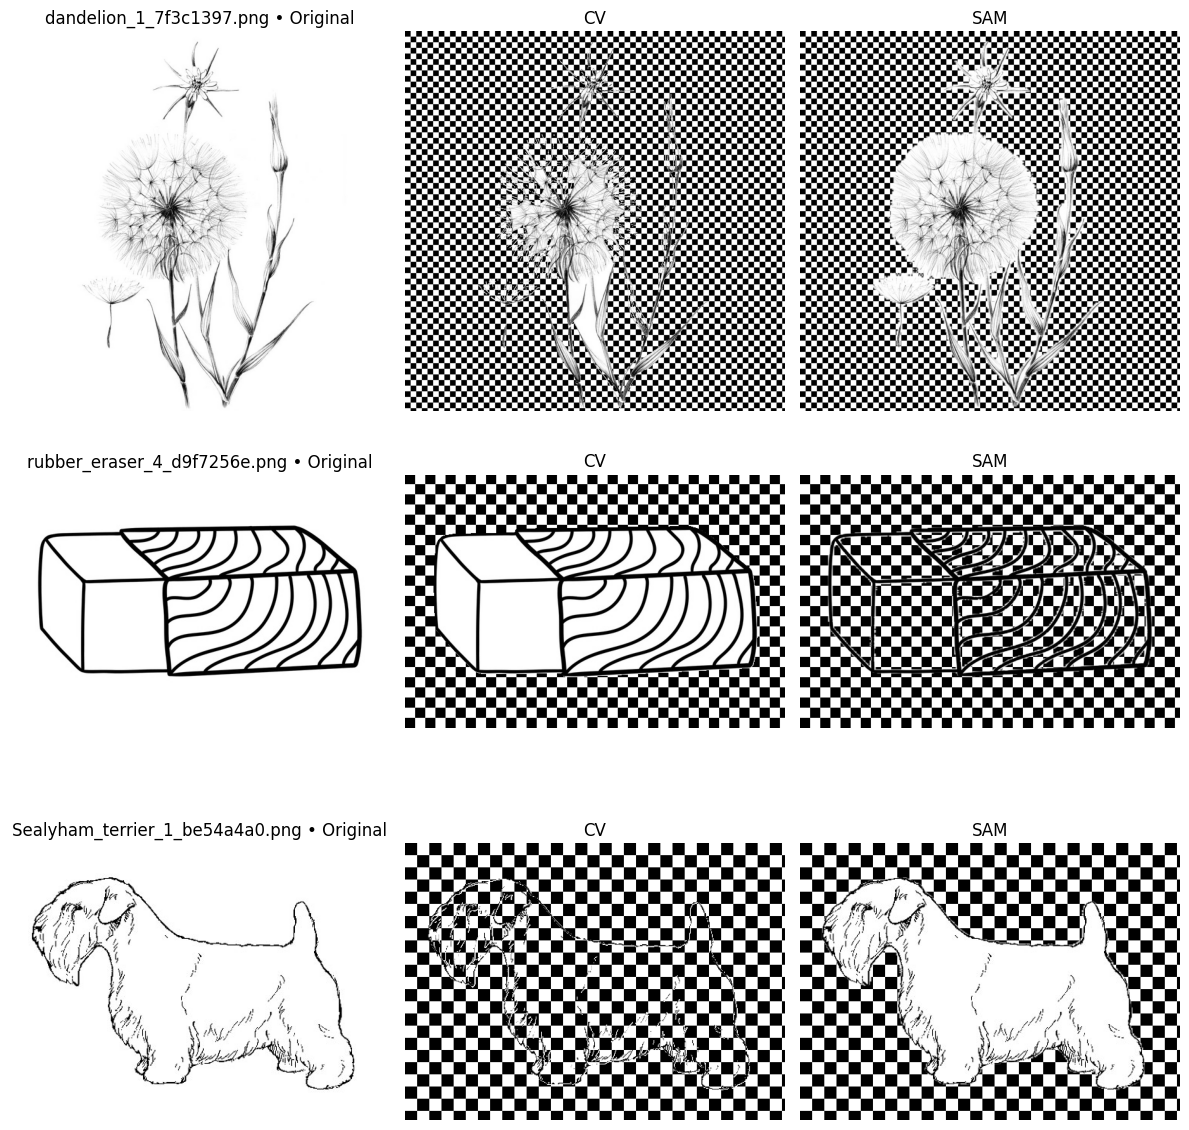

In [15]:
# Initial run, no gaps closed
create_masks(df, dilate_px=1, close_px=2)
show_gallery(df, k=3)

Images to reprocess: 3


Processing images: 100%|██████████| 3/3 [00:00<00:00, 11.02it/s]


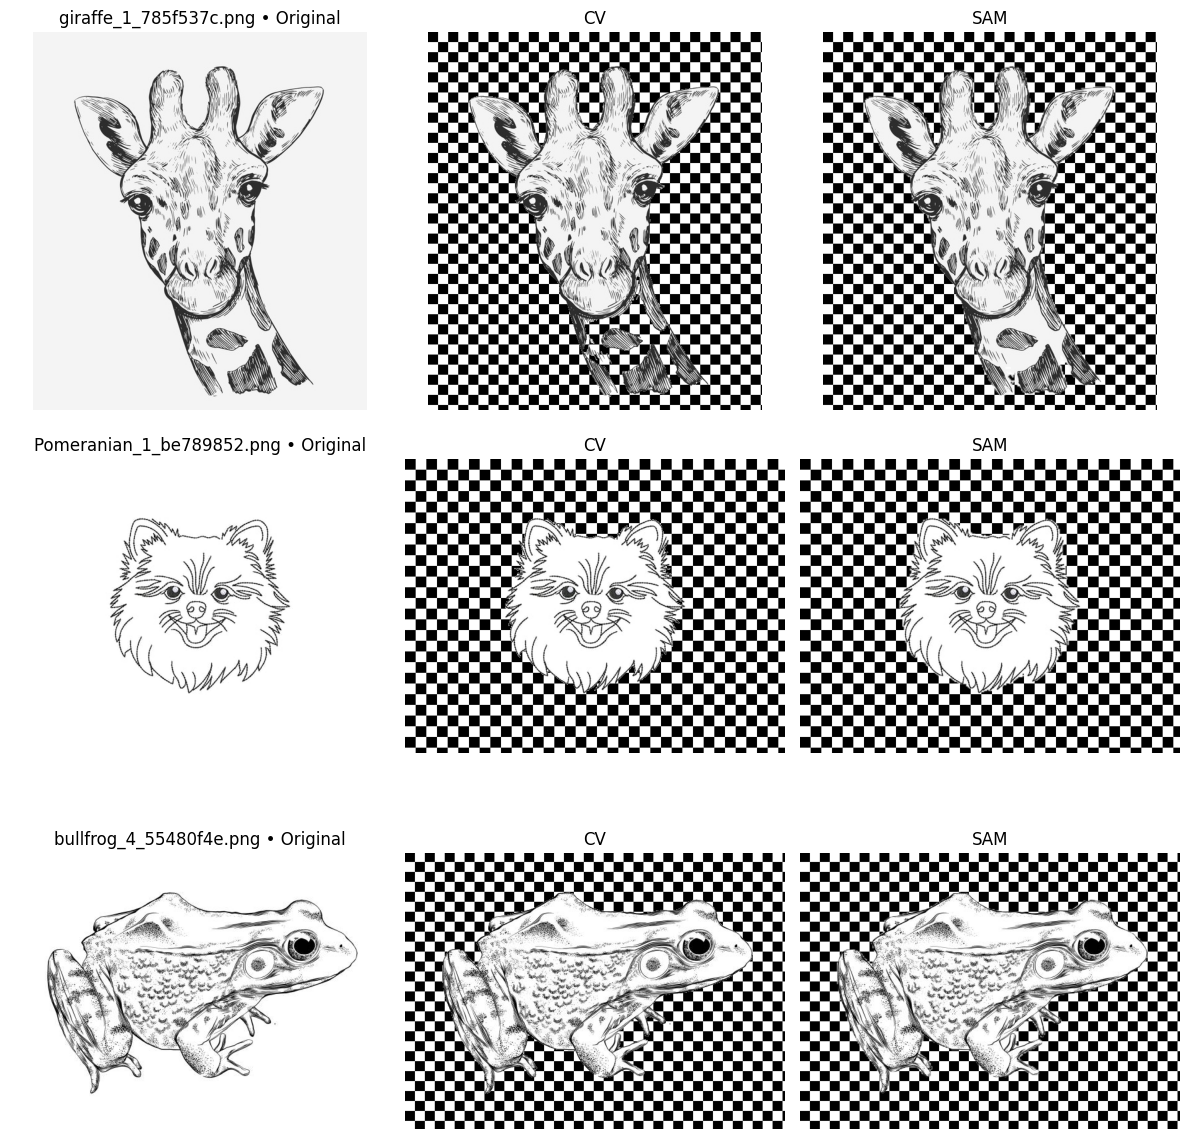

In [16]:
# Second round for slightly larger gaps
objects_with_gaps = {
    "bullfrog",
    "Pomeranian",
    "giraffe"
}
df_gaps = df[df["object"].isin(objects_with_gaps)].copy()
print("Images to reprocess:", len(df_gaps))
create_masks(df_gaps, dilate_px=1, close_px=3)
show_gallery(df_gaps, k=3)

Images to reprocess: 34
Images in df: 34


Processing images: 100%|██████████| 34/34 [00:03<00:00,  9.48it/s]


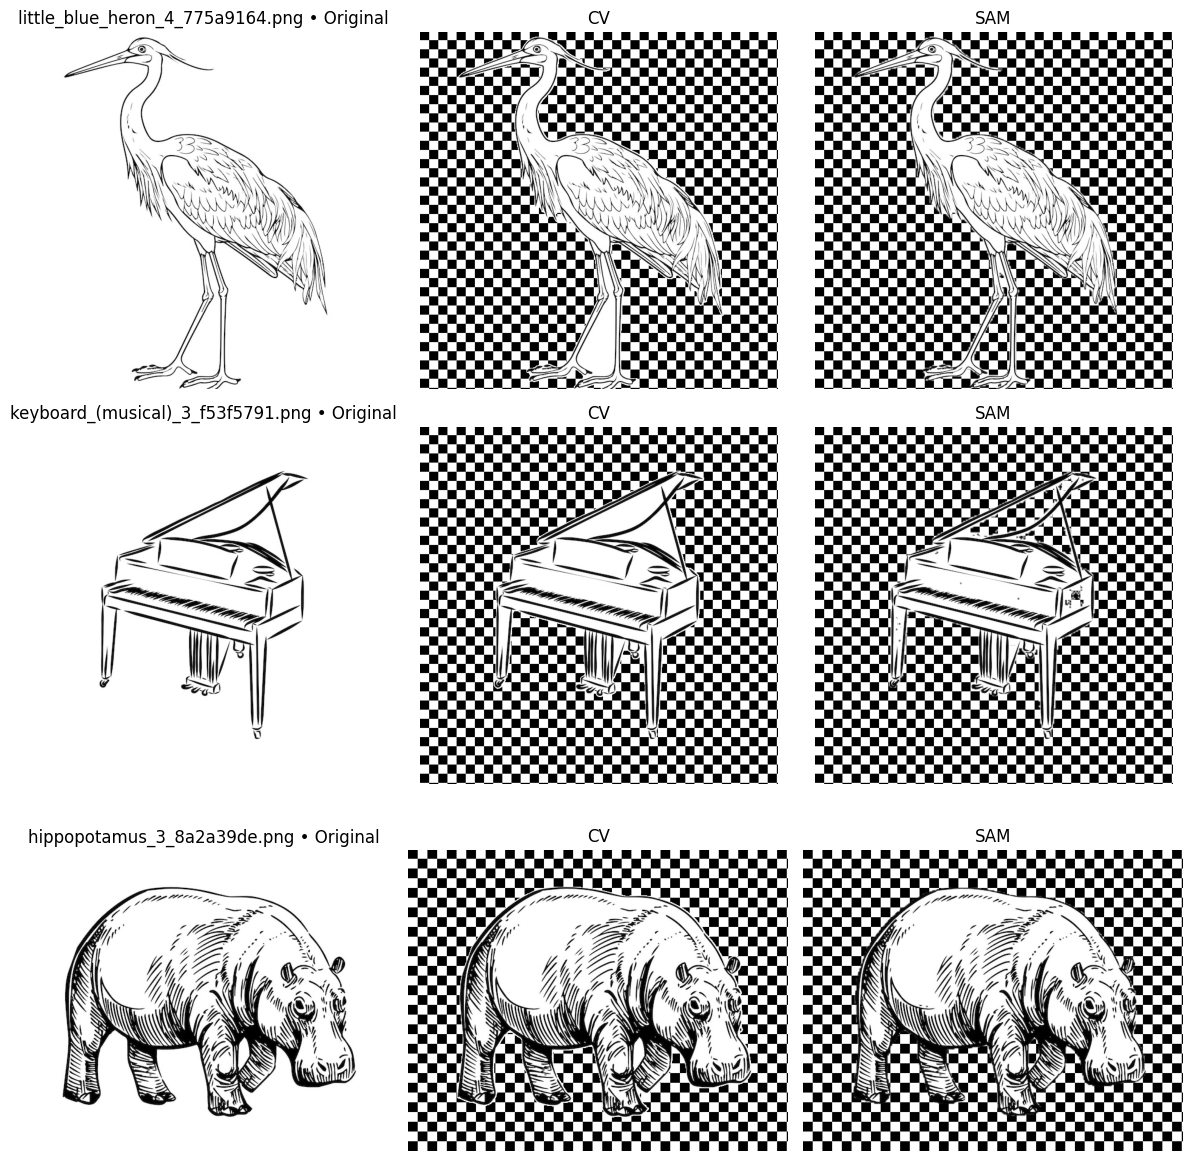

In [17]:
# Third round for large gaps
objects_with_gaps2 = {
    "dandelion",
    "keyboard_(musical)",
    "padlock",
    "cheetah",
    "crown",
    "oak",
    "beets",
    "flat-coated retriever",
    "curly-coated retriever",
    "Labrador retriever",
    "asparagus",
    "Chesapeake Bay retriever",
    "little blue heron",
    "hippopotamus",
    "spoonbill",
    "elk",
    "Doberman",
    "Old English sheepdog",
    "ringlet",
    "groundhog",
    "sulphur butterfly",
    "rooster",
    "goat",
    "hare",
    "Samoyed",
    "elephant",
    "Christmas stocking",
    "car wheel",
    "Norwegian elkhound",
    "Sealyham terrier",
    "camel",
    "tile roof",
    "cloud",
    "garlic"
}
print("Images to reprocess:", len(objects_with_gaps2))
df_gaps2 = df[df["object"].isin(objects_with_gaps2)].copy()
print("Images in df:", len(df_gaps2))
create_masks(df_gaps2, dilate_px=4, close_px=9)
show_gallery(df_gaps2, k=3)

In [18]:
# Remove images to hard to segement
df = df[~df["object"].isin(["elk", "ringlet", "donkey", "Labrador retriever", "sulphur butterfly", "groundhog"])].copy()
print(f"Remaining images: {len(df)}")

Remaining images: 220


In [140]:
#show_gallery(df, k=224)

In [19]:
test_row = df.iloc[4]

img = Image.open(test_row["image_path"]).convert("RGB")
mask = Image.open(test_row["cv_mask_path"]).convert("L")

img_np = np.array(img)
mask_np = np.array(mask)

print("image shape:", img_np.shape)   # (H, W, 3)
print("mask shape:", mask_np.shape)   # (H, W) ideally


image shape: (360, 595, 3)
mask shape: (360, 595)


In [20]:
df.to_csv(out_path, index=False)